In [1]:
#|default_exp app_v1

## Reimplementing DiffEdit

In this notebook we're going to reimplement the semantic image editing process illustrated in the [DiffEdit](https://arxiv.org/abs/2210.11427) paper. In the paper, the authors proposed using text input to create a mask of the queried object, and essentially using an img2img type of processing, such that changes could be made to the object without making changes to the context of the image. 

## Example

<center><img alt="DiffEdit Workflow" width="1000" src="imgs/diffusion_method2.jpg" /></center>

### Imports

In [2]:
#| export
from base64 import b64encode

import os
import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login
from fastai.vision.all import *

from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer


import tsensor
from lolviz import *


import logging

torch_device = "cuda" if torch.cuda.is_available() else "cpu"
logging.getLogger("matplotlib.font_manager").setLevel(logging.ERROR)
logging.disable(logging.WARNING)
torch.manual_seed(1);

In [3]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

## Load Autoencoder, VAE, ClipTokenizer, Clip Text Encoder, and Scheduler

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device).half()
text_encoder = text_encoder.to(torch_device).half()
unet = unet.to(torch_device).half();

## Define Functions for Imamge -> Latent and Latent -> Image Conversion

In [5]:
def pil_to_latent(input_im):
    # Single image -> single latent in a batch, size (1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device).half()*2-1)
    return 0.18215 * latent.latent_dist.sample()

In [6]:
def latent_to_pil(latents):
    # batch of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

***

In [22]:
def get_prompt_embedding(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer(prompt, padding="max_length", max_length=max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        text_embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return text_embeddings

In [8]:
prompt = "a sitting dog"

In [23]:
prompt_embeds = get_prompt_embedding(prompt)

### Import Image

In [7]:
#| export
im = Image.open('imgs/IMG_4104_512.jpg')

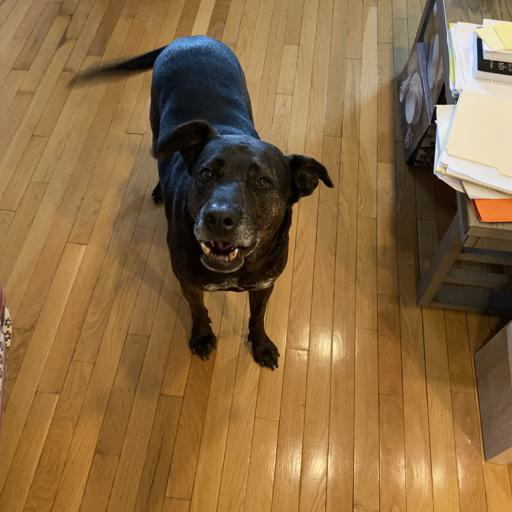

In [8]:
im

## Encode the Image

In [9]:
encoded = pil_to_latent(im)

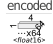

In [10]:
with tsensor.explain():
    encoded

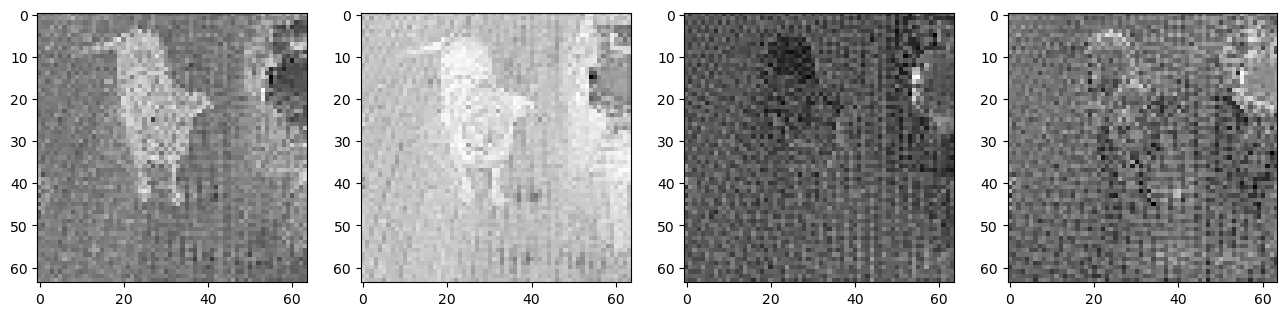

In [11]:
fig, axs = plt.subplots(1, 4, figsize=(16,4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap="Greys")

## Decode the Image

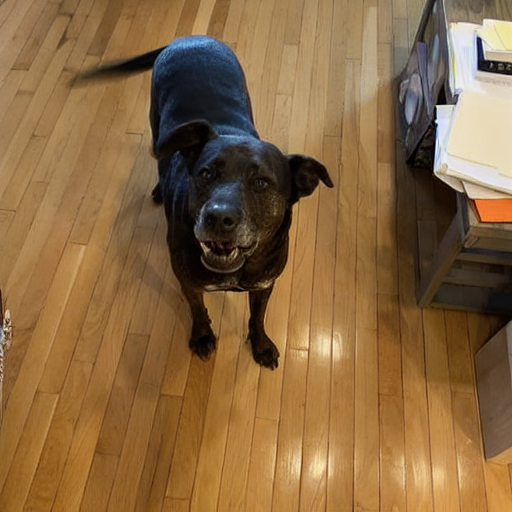

In [14]:
decoded = latent_to_pil(encoded)[0]
decoded

## Set up the Scheduler

Set the number of sampling steps

In [16]:
scheduler.set_timesteps(15)

Print the timesteps, which correspond to the steps used during training

In [17]:
print(scheduler.timesteps)

tensor([999.00, 927.64, 856.29, 784.93, 713.57, 642.21, 570.86, 499.50, 428.14, 356.79, 285.43, 214.07, 142.71,  71.36,   0.00],
       dtype=torch.float64)


Print how much noise is present at each

In [18]:
print(scheduler.sigmas)

tensor([14.61,  9.68,  6.68,  4.77,  3.52,  2.67,  2.06,  1.62,  1.28,  1.01,  0.79,  0.61,  0.44,  0.28,  0.03,  0.00])


Add random noise of the same tensor size as our encoded image

In [28]:
noise = torch.randn_like(encoded).half()

Set our sampling step to step 10 out of the 15 we've defined above

In [29]:
sampling_step = 10

Combine our noise latent with our image latent

In [30]:
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))

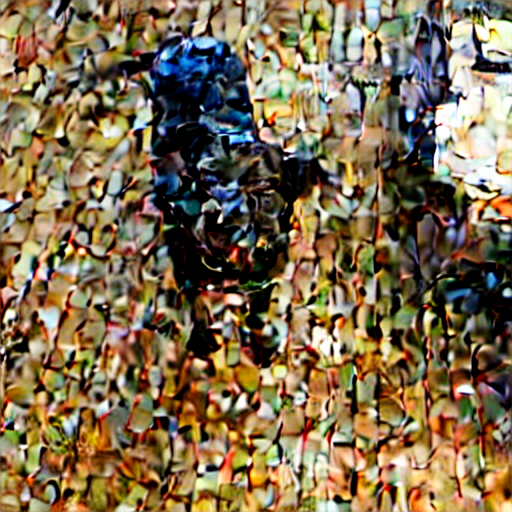

In [32]:
latent_to_pil(encoded_and_noised.half())[0]

In [ ]:
height = 512
width = 512
batch_size = 1

In [ ]:
import nbdev
nbdev.export.nb_export('diffedit.ipynb', 'app_v1')
print("export successful")